The following load the data Cifar 10 data. 

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [21]:
import _pickle as pickle
import numpy as np
import os


def get_CIFAR10_data(cifar10_dir, num_training=49000, num_validation=1000, num_test=1000):
    '''
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the neural net classifier.
    '''
    # Load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    X_train = X_train.astype(np.float64)
    X_val = X_val.astype(np.float64)
    X_test = X_test.astype(np.float64)

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2)
    X_val = X_val.transpose(0, 3, 1, 2)
    X_test = X_test.transpose(0, 3, 1, 2)
    mean_image = np.mean(X_train, axis=0)
    std = np.std(X_train)

    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    X_train /= std
    X_val /= std
    X_test /= std

    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'mean': mean_image, 'std': std
    }


def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding ='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)
        Y = np.array(Y)
        return X, Y


def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [22]:
Dict = {}
Dict = get_CIFAR10_data('cifar-10-batches-py/')

val_data = Dict['X_val']
val_labels = Dict['y_val']

test_data = Dict['X_test']
test_labels = Dict['y_test']

training_data = Dict['X_train']
training_labels = Dict['y_train']

print(training_data.shape)
print(training_labels.shape)

train_x  = torch.from_numpy(training_data)
train_y = training_labels.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(49000, 3, 32, 32)
(49000,)


(torch.Size([49000, 3, 32, 32]), torch.Size([49000]))

In [23]:
# converting validation images into torch format
val_x  = torch.from_numpy(val_data)

# converting the target into torch format
val_y = val_labels.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([1000, 3, 32, 32]), torch.Size([1000]))

In [32]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [33]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [31]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'weight'

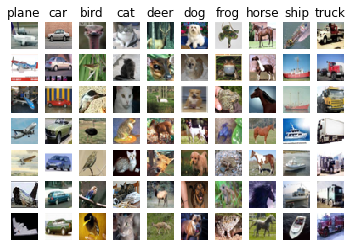

In [18]:
import matplotlib.pyplot as plt

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Ytr == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(Xtr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [26]:
Xtr, Ytr, Xte, Yte = load(r'data\cifar-10-batches-py')

In [35]:
class cifar_clasify(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(3,16,3)
        self.BNorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3)
        self.BNorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*6*6,256)
        self.fc2 = nn.Linear(256,512)
        self.fc3 = nn.Linear(512,10)

        self.drop = nn.Dropout(p =0.2)

    def forward(self,x):

        out = self.conv1(x)
        out = F.relu(out)
        #print(out.shape)
        out = F.max_pool2d(out,2)
        out = self.BNorm1(out)
        #print(out.shape)

        out = self.conv2(out)
        out = F.relu(out)
        #print(out.shape)
        out = F.max_pool2d(out,2)
        out = self.BNorm2(out)
        #print(out.shape)
        out = out.view(out.shape[0],-1)

        out = self.fc1(out)
        out = self.drop(F.relu(out))
        out = self.fc2(out)
        out = self.drop(F.relu(out))
        final = F.log_softmax(F.relu(self.fc3(out)) , dim = 1)

        return final

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = cifar_clasify()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr =0.03)

epoch =2 
step = 2
running_loss = 0
accuracy = 0 
print_every = 5

model.to(device)


for e in range(epoch):

    for inputs,label_ in zip(Xtr, Ytr):

        step +=1
        inputs = inputs.view((-1,3,32,32))
        inputs,label_ = inputs.to(device) , label_.to(device)

        #inputs.cuda()
        #label.cuda()

        optimizer.zero_grad()

        logps = model.forward(inputs)

        loss = criterion(logps , label_.reshape(1))

        loss.backward()

        optimizer.step()

cpu


NameError: name 'Xtr' is not defined

In [ ]:
image = image.transpose((2, 0, 1))